In [1]:
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.ticker import PercentFormatter
from epiweeks import Week
from datetime import datetime, timedelta
from matplotlib.patches import Circle
from matplotlib.lines import Line2D
import numpy as np
from utils import timeseries_formatting, basic_formatting, dec_to_date, hpd, _toYearFraction
from dendropy import TreeList, Tree
import time
import seaborn as sns

prop = mpl.font_manager.FontProperties('Roboto')
mpl.rcParams['font.sans-serif'] = prop.get_name()
mpl.rcParams['font.family'] = 'sans-serif'
mpl.rcParams['font.weight']=300
mpl.rcParams['axes.labelweight']=300
mpl.rcParams['font.size']=16

COLOR = '#343434'
mpl.rcParams['text.color'] = COLOR
mpl.rcParams['axes.labelcolor'] = COLOR
mpl.rcParams['xtick.color'] = COLOR
mpl.rcParams['ytick.color'] = COLOR

# Figure X: Estimated importation risk into San Diego.
Estimated weekly travel counts into San Diego show both the magnitude and temporal dynamics of travel into San Diego during the pandemic.

We first load in the inferred infections for each location being analyses. `back-calculated-infections.csv` is generated with the `calculate-infections.R` script.

In [2]:
infections = pd.read_csv( "estimated-importation-risk/back-calculated-infections.csv", parse_dates=["date"] )
infections = infections.loc[infections["population"]!=0]
infections = infections.drop( columns=["Unnamed: 0"])
infections.head()

,date,location,presymptomatic_cases,asymptomatic_cases,estimated_infections,deaths,cases,population,naive_infections
23,2020-02-12,Afghanistan,0.0,0.0,0.0,0,0,38928341,0.0
24,2020-02-13,Afghanistan,0.0,0.0,0.0,0,0,38928341,0.0
25,2020-02-14,Afghanistan,0.0,0.0,0.0,0,0,38928341,0.0
26,2020-02-15,Afghanistan,0.0,0.0,0.0,0,0,38928341,0.0
27,2020-02-16,Afghanistan,0.0,0.0,0.0,0,0,38928341,0.0


We next load mobility data from SafeGraph that has been prepared as in Zeller et al. 2020. As described in `figureX_mobility-into-san-diego.ipynb` we corrected an artifact we observed in the international mobility data. We also interpolate daily traveler counts from the weekly counts provided by SafeGraph.

In [3]:
def fill_visitors( entry, smooth=True ):
    first = entry.iloc[0]
    entry = entry.set_index( "date_range_start" )
    entry = entry.reindex( pd.date_range( entry.index.min(), entry.index.max() ) )
    entry["week"] = entry.index.map( lambda x: Week.fromdate(x).startdate() )
    entry["true_visitor_count"] = entry.groupby( "week")["true_visitor_count"].transform( lambda x: x.sum() / 7 )
    entry["corrected_visitor_count"]  = entry.groupby( "week" )["corrected_visitor_count"].transform( lambda x: x.sum() / 7 )
    if smooth:
        entry["true_visitor_count"] = entry["true_visitor_count"].rolling( 7, min_periods=1 ).mean()
        entry["corrected_visitor_count"] = entry["corrected_visitor_count"].rolling( 7, min_periods=1 ).mean()
    entry["location"] = first["location"]
    return entry.reset_index()

def correct_mobility( entry ):
    start = "2019-03-01"
    end = "2019-12-29"

    return_df = entry.copy()
    mean2019 = entry.loc[entry["date_range_start"] < start,"true_visitor_count"].mean()
    mean2020 = entry.loc[entry["date_range_start"].between( end, "2020-03-01"),"true_visitor_count"].mean()
    ratio = mean2019 / mean2020


    return_df["corrected_visitor_count"] = return_df["true_visitor_count"]
    if (mean2019 == 0) or (mean2020 == 0):
        return return_df

    return_df.loc[entry["date_range_start"] > end, "corrected_visitor_count"] = return_df["true_visitor_count"] * ratio
    return return_df

st = pd.read_csv( "../data/mobility_states.csv", parse_dates=["date_range_start"] )
st = st.drop( columns=["California"] )
st = st.melt( id_vars=["date_range_start"], var_name="location", value_name="true_visitor_count" )

cr = pd.read_csv("../data/mobility_countries.csv", parse_dates=["date_range_start"] )
cr = cr.drop( columns=["Georgia", "United States"] )
cr = cr.melt( id_vars=["date_range_start"], var_name="location", value_name="true_visitor_count" )

ca = pd.read_csv( "../data/mobility_ca-counties.csv", parse_dates=["date_range_start"] )
ca = ca.melt( id_vars=["date_range_start"], var_name="location", value_name="true_visitor_count" )

mob = pd.concat( [st, cr, ca] )
mob = mob.groupby( "location" ).apply( correct_mobility ).reset_index( drop=True )
mob = mob.groupby( "location" ).apply( fill_visitors ).reset_index( drop=True )

/var/folders/ct/hf5sjtrx29q3hzh3tqrd53740000gn/T/ipykernel_21359/353569865.py:21: RuntimeWarning: invalid value encountered in double_scalars
  ratio = mean2019 / mean2020
/var/folders/ct/hf5sjtrx29q3hzh3tqrd53740000gn/T/ipykernel_21359/353569865.py:21: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = mean2019 / mean2020


Merge mobility and infections dataset. Removing locations without either travelers or infections.

In [4]:
mob = mob.merge( infections, left_on=["location", "index"], right_on=["location", "date"], how="left" )
mob.loc[mob["index"].isna(),"index"] = mob["date"]
mob = mob.drop( columns=["date"] )
mob = mob.rename( columns={"index" : "date"} )
mob["population"] = mob.groupby( "location" )["population"].transform( "max" )

empty_locations = np.setdiff1d( mob.location.unique(), infections["location"].unique() )
mob = mob.loc[~mob["location"].isin(empty_locations)]

mob.head()

,date,location,true_visitor_count,corrected_visitor_count,week,presymptomatic_cases,asymptomatic_cases,estimated_infections,deaths,cases,population,naive_infections
0,2019-01-07,Afghanistan,4.366642,4.366642,2019-01-06,NaN,NaN,NaN,NaN,NaN,38928341.0,NaN
1,2019-01-08,Afghanistan,4.366642,4.366642,2019-01-06,NaN,NaN,NaN,NaN,NaN,38928341.0,NaN
2,2019-01-09,Afghanistan,4.366642,4.366642,2019-01-06,NaN,NaN,NaN,NaN,NaN,38928341.0,NaN
3,2019-01-10,Afghanistan,4.366642,4.366642,2019-01-06,NaN,NaN,NaN,NaN,NaN,38928341.0,NaN
4,2019-01-11,Afghanistan,4.366642,4.366642,2019-01-06,NaN,NaN,NaN,NaN,NaN,38928341.0,NaN


We calculate estimated infection rate as the sum of travellers that arrived from each location and the infection rate at that location.

We also remove dates that we don't estimate infections for. Not sure what to make of these at the moment.

In [5]:
mob = mob.fillna( 0.0 )
mob["estimated_infections"] = mob["estimated_infections"] / mob["population"]
mob["cases"] = mob["cases"] / mob["population"]
mob["eii_mean"] = mob["estimated_infections"] * mob["corrected_visitor_count"]
mob.head()

,date,location,true_visitor_count,corrected_visitor_count,week,presymptomatic_cases,asymptomatic_cases,estimated_infections,deaths,cases,population,naive_infections,eii_mean
0,2019-01-07,Afghanistan,4.366642,4.366642,2019-01-06,0.0,0.0,0.0,0.0,0.0,38928341.0,0.0,0.0
1,2019-01-08,Afghanistan,4.366642,4.366642,2019-01-06,0.0,0.0,0.0,0.0,0.0,38928341.0,0.0,0.0
2,2019-01-09,Afghanistan,4.366642,4.366642,2019-01-06,0.0,0.0,0.0,0.0,0.0,38928341.0,0.0,0.0
3,2019-01-10,Afghanistan,4.366642,4.366642,2019-01-06,0.0,0.0,0.0,0.0,0.0,38928341.0,0.0,0.0
4,2019-01-11,Afghanistan,4.366642,4.366642,2019-01-06,0.0,0.0,0.0,0.0,0.0,38928341.0,0.0,0.0


We plot the absolute importation risk from the five locations with the most importation risk into San Diego in total.

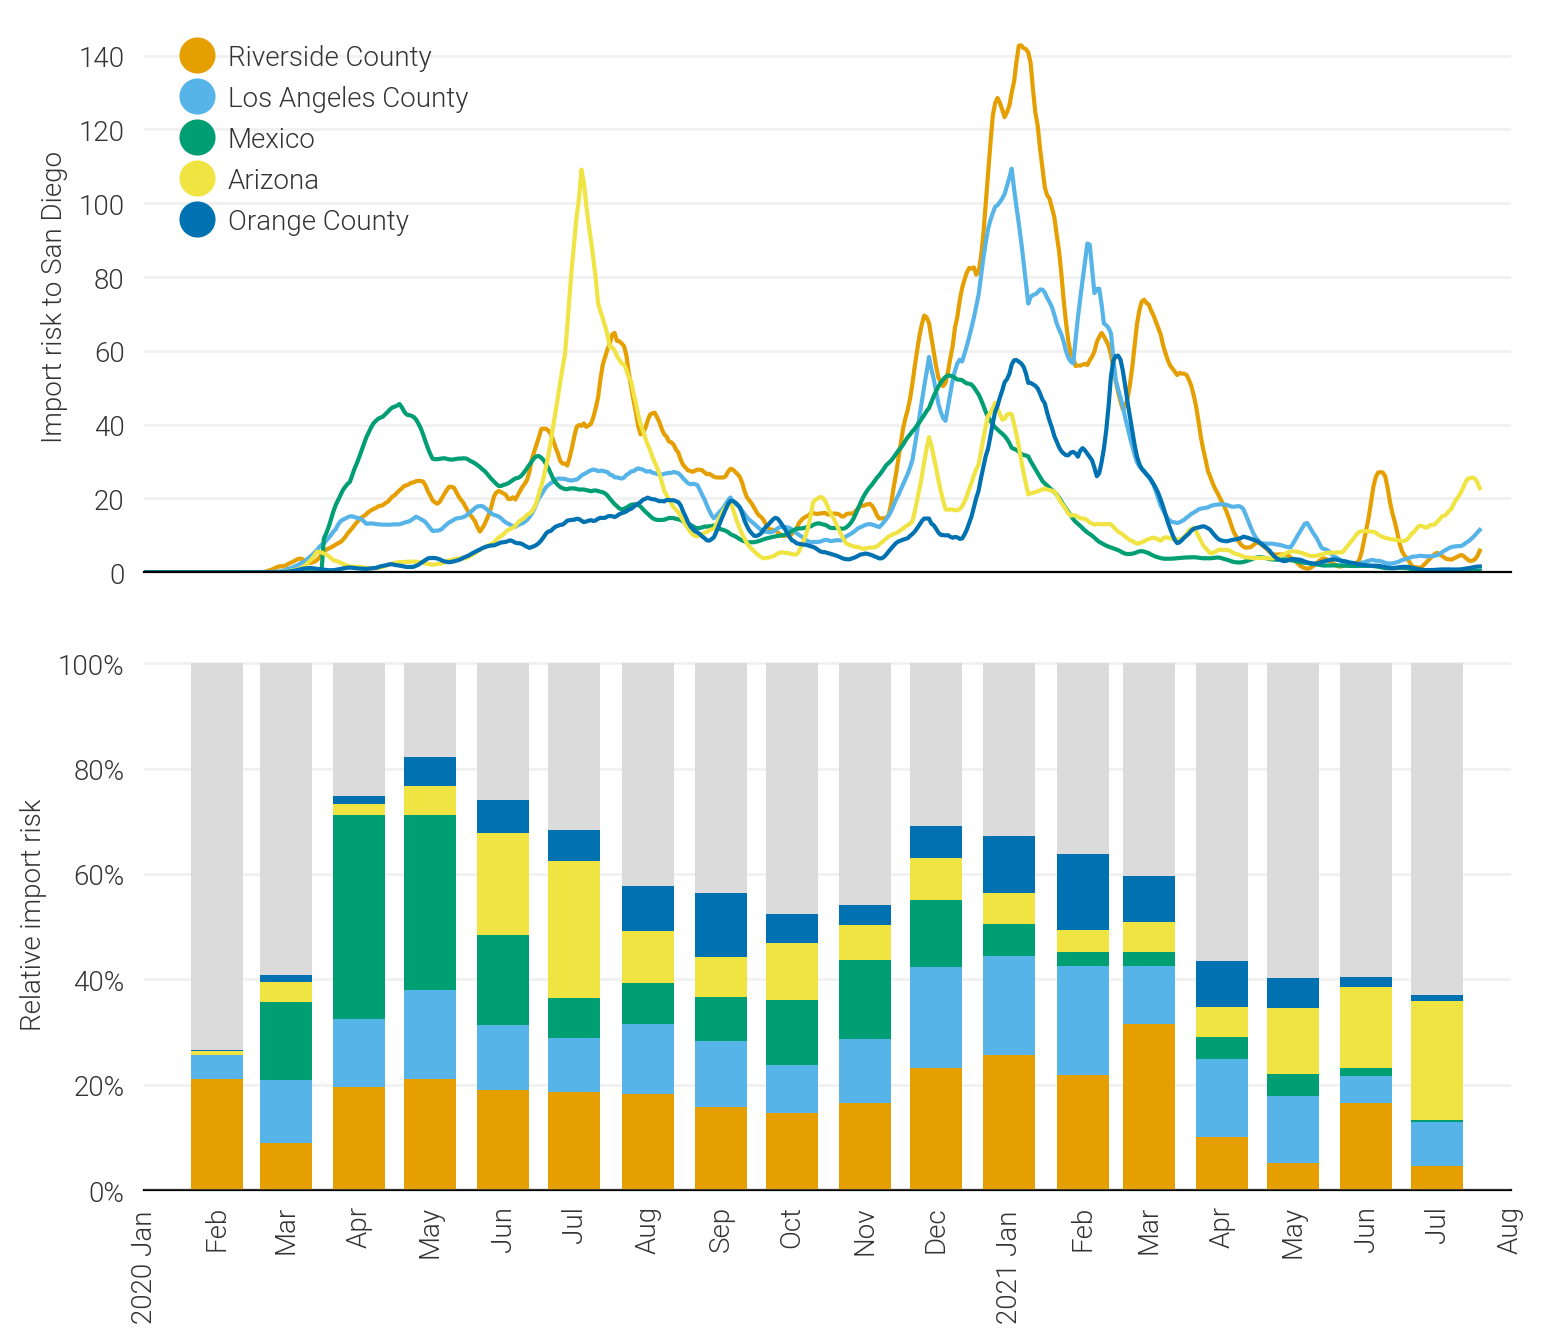

In [6]:
paired = ["#E69F00", "#56B4E9", "#009E73", "#F0E442", "#0072B2", "#D55E00", "#CC79A7"]

def plot_eii_top( df, ax, colors, date_range=None, xsize=10, ysize=10, labelsize=10 ):
    top = df.groupby( "location" )["eii_mean"].sum().sort_values( ascending=False ).index[:5]
    top_df = df.loc[df["location"].isin(top)]
    unique = len( df["location"].unique() )

    for i, j in zip( top, colors ):
        ax.plot( "date", "eii_mean", color=j, data=df.loc[df["location"]==i] )
    #sns.lineplot( x="date", y="eii_mean", hue="location", hue_order=top, palette=colors, data=top_df, ax=ax )
    #sns.lineplot( x="date", y="eii_mean", hue="location", palette=["#969696"]*(unique-6), data=df.loc[~df["location"].isin(top)] )

    ax.xaxis.set_minor_locator( mdates.MonthLocator() )
    ax.xaxis.set_minor_formatter( mdates.DateFormatter( '%b' ) )
    ax.xaxis.set_major_locator( mdates.YearLocator() )
    ax.xaxis.set_major_formatter( mdates.DateFormatter( '%Y %b' ) )

    ax.tick_params( axis="x", which="both", rotation=90 )
    [ax.spines[j].set_visible(False) for j in ax.spines if j not in ["bottom"]]
    ax.tick_params( axis="x", bottom=False, which="both", labelbottom=True, labelsize=xsize )
    ax.tick_params( axis="y", left=False, which="both", labelleft=True, labelsize=ysize )
    ax.grid( which="both", axis="y", linewidth=1, color="#F1F1F1", zorder=1  )
    ax.set_ylabel( "Import risk to San Diego", fontsize=ysize )
    ax.set_xlabel(None)

    # Make my own legend
    #ax.get_legend().remove()
    legend = [Line2D([0], [0], linestyle='none', marker='o', color=j, label=i, markersize=12 ) for i, j in zip( top, colors )]
    ax.legend( loc="upper left", handletextpad=0.1, handles=legend, frameon=False, fontsize=labelsize )

    ax.set_ylim(0)
    if date_range is None:
        ax.set_xlim( pd.to_datetime( "2020-01-01" ), pd.to_datetime( "2021-08-01" ) )
    else:
        ax.set_xlim( *date_range )

def plot_eii_relative( df, ax, colors, top, date_range=None, xsize=10, ysize=10, counter=False ):
    value = "eii_counter" if counter else "eii_mean"
    plot_df = df.pivot( index="date", columns="location", values=value )
    plot_df["month"] = plot_df.index.strftime('%Y-%m-01' )
    plot_df = plot_df.reset_index( drop=True ).groupby( "month" ).sum()
    plot_df = plot_df.reindex( columns=plot_df.sum().sort_values( ascending=False ).index )

    top_df = plot_df[top]
    bottom_df = plot_df.drop( columns=top ).sum( axis=1 )
    bottom_df.name = "Other"

    # Collapse to just the top 6 and other
    plot_df = pd.concat( [top_df, bottom_df], axis=1 )
    plot_df = plot_df.apply( lambda x: x/x.sum(), axis=1 )

    plot_df.index = mdates.datestr2num( plot_df.index ).astype( int )

    bottom = np.zeros( plot_df.shape[0] )
    for i, j in zip( plot_df.columns, colors[:len( top )]+["#DBDBDB"] ):
        #print( plot_df[i] )
        ax.bar( x=plot_df.index, height=plot_df[i].fillna(0), bottom=bottom, color=j, width=22, zorder=10, align="center" )
        bottom += plot_df[i].fillna(0).to_list()


    ax.xaxis.set_minor_locator( mdates.MonthLocator() )
    ax.xaxis.set_minor_formatter( mdates.DateFormatter( '%b' ) )
    ax.xaxis.set_major_locator( mdates.YearLocator() )
    ax.xaxis.set_major_formatter( mdates.DateFormatter( '%Y %b' ) )

    ax.tick_params( axis="x", which="both", rotation=90 )
    [ax.spines[j].set_visible(False) for j in ax.spines if j not in ["bottom"]]
    ax.tick_params( axis="x", bottom=False, which="both", labelbottom=True, labelsize=xsize )
    ax.tick_params( axis="y", left=False, which="both", labelleft=True, labelsize=ysize )
    ax.set_ylabel( "Relative import risk", fontsize=ysize )
    ax.set_xlabel(None)
    ax.yaxis.set_major_formatter(PercentFormatter(1))
    #ax.get_legend().remove()
    ax.grid( which="both", axis="y", linewidth=1, color="#F1F1F1", zorder=1 )
    ax.axhline( 0, color=COLOR, linewidth=1, zorder=11 )

    if date_range is None:
        ax.set_xlim( pd.to_datetime( "2020-01-01" ), pd.to_datetime( "2021-08-01" ) )
    else:
        ax.set_xlim( *date_range )


    plot_df.index = mdates.num2date( plot_df.index )
    plot_df.index = plot_df.index.date
    plot_df = plot_df.dropna(how="all")
    return plot_df

fig, ax = plt.subplots( dpi=200, figsize=(8,7), nrows=2 )
plot_eii_top( mob, ax[0], paired )
top = mob.groupby( "location" )["eii_mean"].agg(sum).sort_values( ascending=False ).index[:5]
eii_normal = plot_eii_relative( mob, ax[1], paired, top=top )
ax[0].label_outer()
plt.tight_layout()
plt.savefig( "../analyses/plots/figureX_estimated-importation-risk.pdf" )
plt.show()

Calculate the cumulative percentage of estimated importation risk for the Top N locations.

In [7]:
cumulative_percentage = mob.groupby( "location" )["eii_mean"].sum().sort_values( ascending=False )
cumulative_percentage = cumulative_percentage.cumsum() / cumulative_percentage.sum()
cumulative_percentage.head(50)

location
Riverside County         0.199479
Los Angeles County       0.345708
Mexico                   0.449493
Arizona                  0.546969
Orange County            0.621742
San Bernardino County    0.680491
Imperial County          0.719210
Texas                    0.751934
Nevada                   0.775993
Florida                  0.794792
New York                 0.806192
Illinois                 0.817281
Kern County              0.825502
Colorado                 0.833578
Michigan                 0.840991
Washington               0.847839
Georgia                  0.854216
Sacramento County        0.860072
Ohio                     0.865565
Ventura County           0.870969
Pennsylvania             0.876312
Virginia                 0.881187
North Carolina           0.885833
Santa Clara County       0.890427
Missouri                 0.894898
Oklahoma                 0.899339
Tennessee                0.903641
Indiana                  0.907924
Minnesota                0.912024
New J

To estimate whether the top locations dominate the importation risk into San Diego across the entire epidemic, we calculate the Gini coefficient of monthly importation risk into San Diego.

In [8]:
def gini(x):
    # (Warning: This is a concise implementation, but it is O(n**2)
    # in time and memory, where n = len(x).  *Don't* pass in huge
    # samples!)

    # Mean absolute difference
    mad = np.abs(np.subtract.outer(x, x)).mean()
    # Relative mean absolute difference
    rmad = mad/np.mean(x)
    # Gini coefficient
    g = 0.5 * rmad
    return g

mob_month = mob.pivot( index="date", columns="location", values="eii_mean" )
mob_month["month"] = mob_month.index.strftime('%Y-%m-01' )
mob_month = mob_month.reset_index( drop=True ).groupby( "month" ).sum()
mob_month = mob_month.reindex( columns=mob_month.sum().sort_values( ascending=False ).index )

results = {
    "date" : [],
    "gini_median" : [],
    "gini_upper" : [],
    "gini_lower" : [],
}

# Bootstrap Gini inequality
for month, entry in mob_month.iterrows():
    results["date"].append( month )
    bootstraps = []
    for _ in range( 1000 ):
        boot_entry = entry.sample( frac=1, replace=True ).to_numpy()
        bootstraps.append( gini( boot_entry ) )
    results["gini_median"].append( np.quantile( bootstraps, 0.5 ) )
    results["gini_lower"].append( np.quantile( bootstraps, 0.025 ) )
    results["gini_upper"].append( np.quantile( bootstraps, 0.975 ) )
gini_results = pd.DataFrame( results )
gini_results["date"] = pd.to_datetime( gini_results["date"] )
gini_results.dropna()

/var/folders/ct/hf5sjtrx29q3hzh3tqrd53740000gn/T/ipykernel_21359/2437662166.py:9: RuntimeWarning: invalid value encountered in double_scalars
  rmad = mad/np.mean(x)


,date,gini_median,gini_upper,gini_lower
13,2020-02-01,0.939785,0.957694,0.893484
14,2020-03-01,0.913644,0.937905,0.872965
15,2020-04-01,0.948364,0.966093,0.884274
16,2020-05-01,0.952541,0.965818,0.904385
17,2020-06-01,0.945895,0.958007,0.924547
18,2020-07-01,0.938900,0.955300,0.908540
19,2020-08-01,0.921574,0.941309,0.897422
20,2020-09-01,0.905726,0.927460,0.871772
21,2020-10-01,0.887049,0.913248,0.842974
22,2020-11-01,0.890944,0.917861,0.840882


Here we plot the Gini coefficient over time, with uncertainty from bootstrapping.

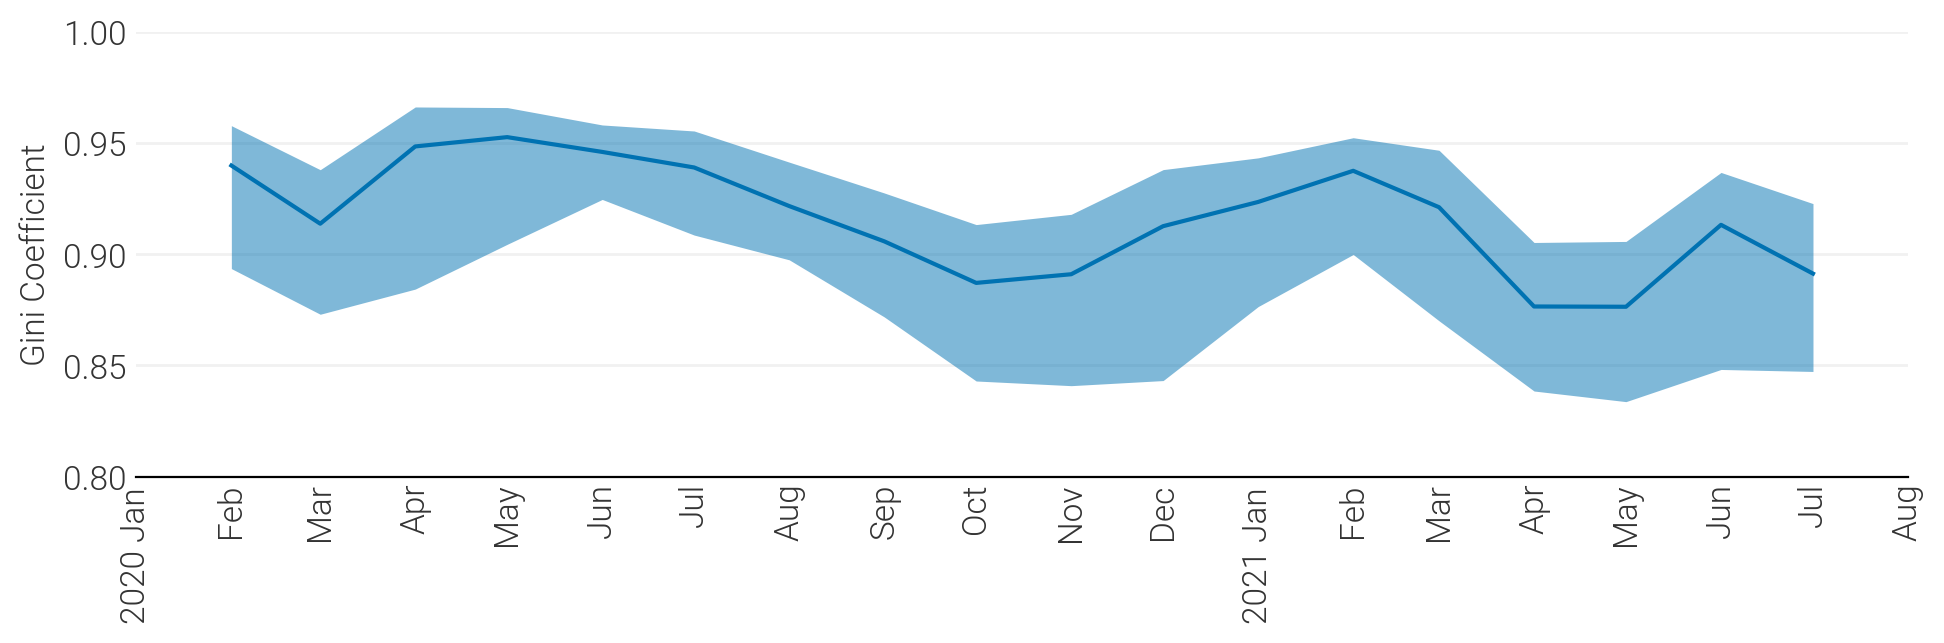

In [9]:
fig, ax = plt.subplots( dpi=200, figsize=(10,3.5) )
ax.plot( "date", "gini_median", data=gini_results, color=paired[4], zorder=100 )
ax.fill_between( "date", "gini_upper", "gini_lower", data=gini_results, color=paired[4], alpha=0.5, linewidth=0, zorder=90 )
basic_formatting( ax, ylabel="Gini Coefficient", ylims=(0.8, 1), xlims=(pd.to_datetime("2020-01-01"), pd.to_datetime("2021-08-01")) )
timeseries_formatting( ax )
plt.tight_layout()
plt.show()

Gini coefficient describes how varied the importation sources are in San Diego across the entire pandemic. As part of our phylosor analysis, we saw that the variance in genomic similar to other locations changed over the course of the pandemic. We hypothesize that this is not by chance, and that genomic similarity to other locations is directly correlated to the importations from that location. Here we determine the correlation between the Gini coefficient and variance in phylosor measurements. PhyloSor standard deviation is calculated by `figure1_phylosor-similarity.ipynb`.

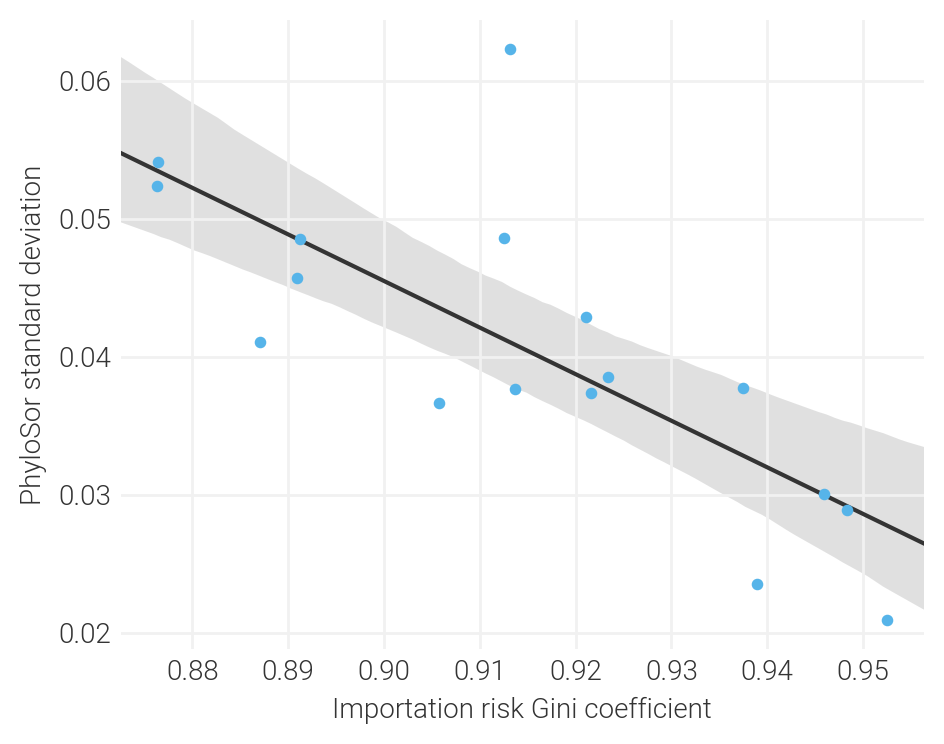

In [10]:
phylosor_std = pd.read_csv( "../data/phylosor_std.csv", names=["date", "phylosor_std"], header=0, parse_dates=["date"] )
plot_df = gini_results.merge( phylosor_std )

fig, ax = plt.subplots( dpi=200, figsize=(5,4) )

ax.scatter( x="gini_median", y="phylosor_std", data=plot_df, color="#56B4E9", s=10, zorder=10 )
sns.regplot( x="gini_median", y="phylosor_std", data=plot_df, color=COLOR, scatter=False, line_kws={"zorder" : 5, "linewidth" : 1.5}, ax=ax, truncate=False )

basic_formatting( ax, spines=[], which="both", xlabel="Importation risk Gini coefficient", ylabel="PhyloSor standard deviation", xsize=10, ysize=10 )
ax.tick_params( axis="x", bottom=False, which="both", labelbottom=True, rotation=0 )
ax.annotate( "June 2021", (0.913154, 0.104903), (10,-20), textcoords='offset points', fontsize=10, arrowprops=dict(arrowstyle="-", color=COLOR ) )
plt.tight_layout()
#plt.savefig( "../analyses/plots/figureX_importation-risk-phylosor-correlation.pdf" )
plt.show()

`regplot` shows the correlation, but doesn't show the slope or significance. We calculate the actual results using OLS.

In [11]:
import statsmodels.api as sm

X = plot_df["gini_median"].to_numpy().reshape(-1, 1)
Y = plot_df["phylosor_std"].to_numpy().reshape(-1, 1)

X2 = sm.add_constant( X )
est = sm.OLS(Y, X2)
est2 = est.fit()
print(est2.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.574
Model:                            OLS   Adj. R-squared:                  0.545
Method:                 Least Squares   F-statistic:                     20.17
Date:                Thu, 04 Aug 2022   Prob (F-statistic):           0.000431
Time:                        11:07:27   Log-Likelihood:                 60.340
No. Observations:                  17   AIC:                            -116.7
Df Residuals:                      15   BIC:                            -115.0
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.3493      0.069      5.077      0.0

/usr/local/lib/python3.9/site-packages/scipy/stats/stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=17
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


In `figureX_mobility-into-san-diego.ipynb` we found that travel into San Diego increased significantly during the weeks surround Thanksgiving, Christmas, and Spring break. We estimate the change in absolute importation risk for these weeks from the previous week.

In [49]:
thanksgiving = mob.loc[mob["date"].between( "2020-11-23", "2020-11-29"),"eii_mean"].sum() / mob.loc[mob["date"].between( "2020-11-16", "2020-11-22"), "eii_mean"].sum()
christmas = mob.loc[mob["date"].between( "2020-12-21", "2020-12-27"),"eii_mean"].sum() / mob.loc[mob["date"].between( "2020-12-14", "2020-12-20"), "eii_mean"].sum()
spring_break = mob.loc[mob["date"].between( "2021-03-15", "2021-04-11"),"eii_mean"].sum() / mob.loc[mob["date"].between( "2021-02-15", "2021-03-14"), "eii_mean"].sum()

print( f"Thanksgiving: {thanksgiving-1:.1%}" )
print( f"Christmas: {christmas-1:.1%}" )
print( f"Spring-break: {spring_break-1:.1%}" )

Thanksgiving: 48.8%
Christmas: 32.3%
Spring-break: -38.4%
